In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
#%%
from keras.datasets import mnist
# from network import *
from keras.utils import np_utils




# %%
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# %%
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


Using TensorFlow backend.
/home/ganesh/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ganesh/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ganesh/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ganesh/anaconda3/lib/python3.6/site-packages/tenso

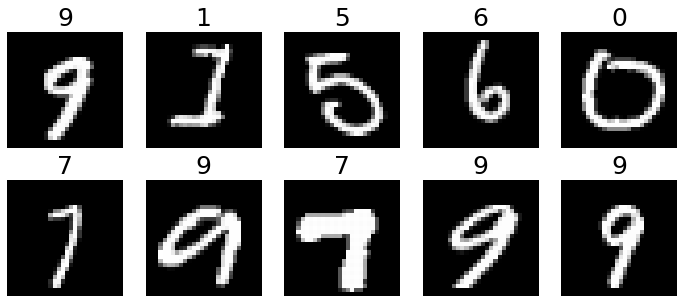

In [6]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,60000,size=10)
for i in range(10):
    axes[i].imshow(X_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

In [7]:
# relu activation function
# THE fastest vectorized implementation for ReLU
def relu(x):
    x[x<0]=0
    return x

In [8]:
def h(X,W,b):
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    
    # add one more layer
    
    # layer 2 activation
    a2 = relu(z1)
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    # the output is a probability for each sample
    return sigma

In [9]:
def softmax(X_in,weights):    
    s = np.exp(np.matmul(X_in,weights))
    total = np.sum(s, axis=1).reshape(-1,1)
    return s / total

In [10]:
def loss(y_pred,y_true):
    global K 
    K = 10
    N = len(y_true)
    # loss_sample stores the cross entropy for each sample in X
    # convert y_true from labels to one-hot-vector encoding
    y_true_one_hot_vec = (y_true[:,np.newaxis] == np.arange(K))
    loss_sample = (np.log(y_pred) * y_true_one_hot_vec).sum(axis=1)
    # loss_sample is a dimension (N,) array
    # for the final loss, we need take the average
    return -np.mean(loss_sample)

In [11]:
def backprop(W,b,X,y,alpha=1e-4):

    K = 10
    N = X.shape[0]
    
    ### Step 1:
    # layer 1 = input layer
    a1 = X
    # layer 1 (input layer) -> layer 2 (hidden layer)
    z1 = np.matmul(X, W[0]) + b[0]
    # layer 2 activation
    a2 = relu(z1)
    
    # one more layer
    
    # layer 2 (hidden layer) -> layer 3 (output layer)
    z2 = np.matmul(a2, W[1])
    s = np.exp(z2)
    total = np.sum(s, axis=1).reshape(-1,1)
    sigma = s/total
    
    ### Step 2:
    
    # layer 2->layer 3 weights' derivative
    # delta2 is \partial L/partial z2, of shape (N,K)
    y_one_hot_vec = (y[:,np.newaxis] == np.arange(K))
    delta2 = (sigma - y_one_hot_vec)
    grad_W1 = np.matmul(a2.T, delta2)
    
    # layer 1->layer 2 weights' derivative
    # delta1 is \partial a2/partial z1
    # layer 2 activation's (weak) derivative is 1*(z1>0)
    delta1 = np.matmul(delta2, W[1].T)*(z1>0)
    grad_W0 = np.matmul(X.T, delta1)
    
    # Student project: extra layer of derivative
    
    # no derivative for layer 1
    
    # the alpha part is the derivative for the regularization
    # regularization = 0.5*alpha*(np.sum(W[1]**2) + np.sum(W[0]**2))
    
    
    dW = [grad_W0/N + alpha*W[0], grad_W1/N + alpha*W[1]]
    db = [np.mean(delta1, axis=0)]
    # dW[0] is W[0]'s derivative, and dW[1] is W[1]'s derivative; similar for db
    return dW, db

In [12]:
eta = 5e-1
alpha = 1e-6 # regularization
gamma = 0.99 # RMSprop
eps = 1e-3 # RMSprop
num_iter = 2000 # number of iterations of gradient descent
n_H = 256 # number of neurons in the hidden layer
n = X_train.shape[1] # number of pixels in an image
K = 10

In [13]:
np.random.seed(1127)
W = [1e-1*np.random.randn(n, n_H), 1e-1*np.random.randn(n_H, K)]
b = [np.random.randn(n_H)]


In [14]:
%%time
gW0 = gW1 = gb0 = 1

for i in range(num_iter):
    dW, db = backprop(W,b,X_train,y_train,alpha)
    
    #RMS Prop
    gW0 = gamma*gW0 + (1-gamma)*np.sum(dW[0]**2)
    etaW0 = eta/np.sqrt(gW0 + eps)
    W[0] -= etaW0 * dW[0]
    
    gW1 = gamma*gW1 + (1-gamma)*np.sum(dW[1]**2)
    etaW1 = eta/np.sqrt(gW1 + eps)
    W[1] -= etaW1 * dW[1]
    
    gb0 = gamma*gb0 + (1-gamma)*np.sum(db[0]**2)
    etab0 = eta/np.sqrt(gb0 + eps)
    b[0] -= etab0 * db[0]
    
    if i % 500 == 0:
        # sanity check 1
        y_pred = h(X_train,W,b)
        print("Cross-entropy loss after", i+1, "iterations is {:.8}".format(
              loss(y_pred,y_train)))
        print("Training accuracy after", i+1, "iterations is {:.4%}".format( 
              np.mean(np.argmax(y_pred, axis=1)== y_train)))
        
        # sanity check 2
        print("gW0={:.4f} gW1={:.4f} gb0={:.4f}\netaW0={:.4f} etaW1={:.4f} etab0={:.4f}"
              .format(gW0, gW1, gb0, etaW0, etaW1, etab0))
        
        # sanity check 3
        print("|dW0|={:.5f} |dW1|={:.5f} |db0|={:.5f}"
             .format(np.linalg.norm(dW[0]), np.linalg.norm(dW[1]), np.linalg.norm(db[0])), "\n")
        
        # reset RMSprop
        gW0 = gW1 = gb0 = 1

y_pred_final = h(X_train,W,b)
print("Final cross-entropy loss is {:.8}".format(loss(y_pred_final,y_train)))
print("Final training accuracy is {:.4%}".format(np.mean(np.argmax(y_pred_final, axis=1)== y_train)))

Cross-entropy loss after 1 iterations is 7.3206937
Training accuracy after 1 iterations is 36.9600%
gW0=1.0709 gW1=1.2172 gb0=0.9919
etaW0=0.4829 etaW1=0.4530 etab0=0.5018
|dW0|=2.84396 |dW1|=4.76648 |db0|=0.43242 

Cross-entropy loss after 501 iterations is 0.098925468
Training accuracy after 501 iterations is 97.0483%
gW0=0.1595 gW1=0.0570 gb0=0.0103
etaW0=1.2480 etaW1=2.0764 etab0=4.7016
|dW0|=0.01843 |dW1|=0.00872 |db0|=0.00181 

Cross-entropy loss after 1001 iterations is 0.085420435
Training accuracy after 1001 iterations is 97.6000%
gW0=0.3210 gW1=0.0749 gb0=0.0141
etaW0=0.8811 etaW1=1.8144 etab0=4.0641
|dW0|=0.03717 |dW1|=0.01417 |db0|=0.00464 

Cross-entropy loss after 1501 iterations is 0.030992409
Training accuracy after 1501 iterations is 99.2300%
gW0=0.0661 gW1=0.0143 gb0=0.0080
etaW0=1.9303 etaW1=4.0381 etab0=5.2671
|dW0|=0.00674 |dW1|=0.00292 |db0|=0.00059 

Final cross-entropy loss is 0.033040989
Final training accuracy is 99.0733%
CPU times: user 3h 5min 50s, sys: 4min

## test accuracy

In [15]:
y_pred_test = np.argmax(h(X_test,W,b), axis=1)

In [16]:
np.mean(y_pred_test==y_test)

0.9734

In [17]:
weights=np.array(W)
bias = np.array(b)
np.save('weights.npy',weights)
np.save('bias.npy',bias)